# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Problem Statement

Prepare a model that is invariant to the transformations and can recognize the varied images.

## Learning Objectives

At the end of the experiment, you will be able to :

* Load and prepare images for the model using Pytorch
* Load and Finetune a pre-trained model for predicting the labels of the transformed images

## Dataset

The dataset is comprised of photos of buildings, forests, glaciers, mountains, sea, and streets provided as a subset of photos.

The dataset has been divided into folders for training, validation, and testing. The training folder includes around 14,000 images and the validation folder has around 3,000 images. Finally, the  testing folder includes around 10 images.

## Grading = 30 Marks

## Setup Steps

In [ ]:
#@title Run this cell to complete the setup for this Notebook

from IPython import get_ipython
ipython = get_ipython()
  
notebook= "U4_Mini_Hackathon2_Image_Transformations" #name of the notebook
Answer = "This notebook is graded by mentors on the day of mini-hackathon"
def setup():
   ipython.magic("sx wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Image_Transformations.zip")
   ipython.magic("sx unzip -qq Image_Transformations.zip")
   print ("Setup completed successfully")
   return

setup()

Setup completed successfully


In [1]:
%ls

sample_data/


## Basic Pytorch packages

**torchvision:**  This package is used to load and prepare the dataset. Using this package we can perform/apply transformations on the input data.

**transforms:**  This package is  used to perform **preprocessing on images** and operations sequentially. 

**nn:**  This package provides an easy and modular way to build and train simple or complex neural networks.

**optim:** This package is used for  implementing various optimization algorithms

In [ ]:
# Import Libraries
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

from torch.optim import lr_scheduler
import time
import copy
import torchvision

import numpy as np



## **Stage 1:** Data Preprocessing

### 3 Marks -> Load the training dataset

In [ ]:
#Loading the training data
train_set = "/content/Image_Transformations/training"
train_data = datasets.ImageFolder(root=train_set)

In [ ]:
# Data Exploration 
print(train_data.classes)



['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
# Classes to index mapping
print(train_data.class_to_idx)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [ ]:
# Number of training data
print(len(train_data))

14034


PIL image size: (150, 150), target: 0


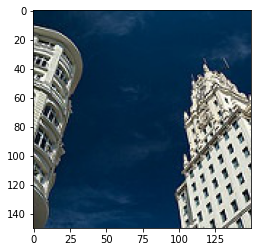

In [ ]:
#Visualize some training images
img, target = train_data[4]
print('PIL image size: {}, target: {}'.format(img.size, target))
plt.imshow(img)
plt.show()

PIL image size: (150, 150), target: 2


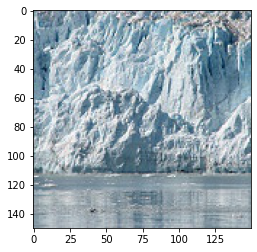

In [ ]:
img, target = train_data[5654]
print('PIL image size: {}, target: {}'.format(img.size, target))
plt.imshow(img)
plt.show()

PIL image size: (150, 150), target: 3


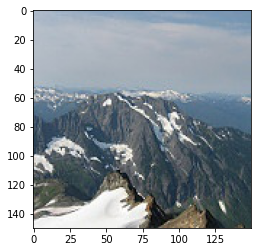

In [ ]:
img, target = train_data[8987]
print('PIL image size: {}, target: {}'.format(img.size, target))
plt.imshow(img)
plt.show()

PIL image size: (150, 150), target: 1


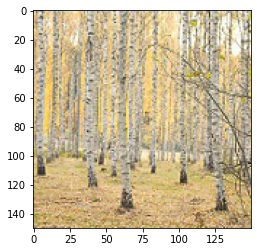

In [ ]:
img, target = train_data[3456]
print('PIL image size: {}, target: {}'.format(img.size, target))
plt.imshow(img)
plt.show()

PIL image size: (150, 150), target: 5


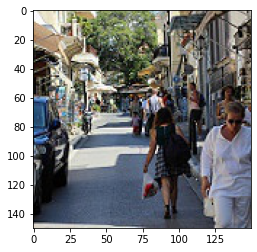

In [ ]:
img, target = train_data[12000]
print('PIL image size: {}, target: {}'.format(img.size, target))
plt.imshow(img)
plt.show()

PIL image size: (150, 150), target: 4


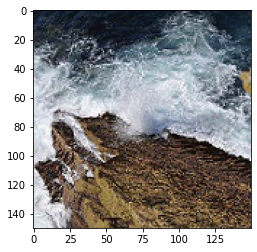

In [ ]:
img, target = train_data[10000]
print('PIL image size: {}, target: {}'.format(img.size, target))
plt.imshow(img)
plt.show()

**Though, we noticed that different images have the same sizes. For futher insurance, in the training phase, we need fixed-size images. So we can use `torchvision.transforms.Resize` to resize images.**

###DataLoader with ImageFolder Dataset

We need to emphsize that our images are in `150 x 150` sized images. Generally, in testing phasing or non rezised trainingset, the image of interest is at the center of the big image. So we can use the following transform:

```
transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(150)
    ])
```



###Our `get_data` method will return the training and validation data loader.

In [ ]:
def get_data(batch_size, data_root, num_workers=4):
    
    preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # train dataloader
    
    train_data_path = os.path.join(data_root, 'training')
    
    train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(root=train_data_path, transform=preprocess),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    
    test_data_path = os.path.join(data_root, 'validation')
    
    test_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(root=test_data_path, transform=preprocess),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

### Plot few preprocessed images

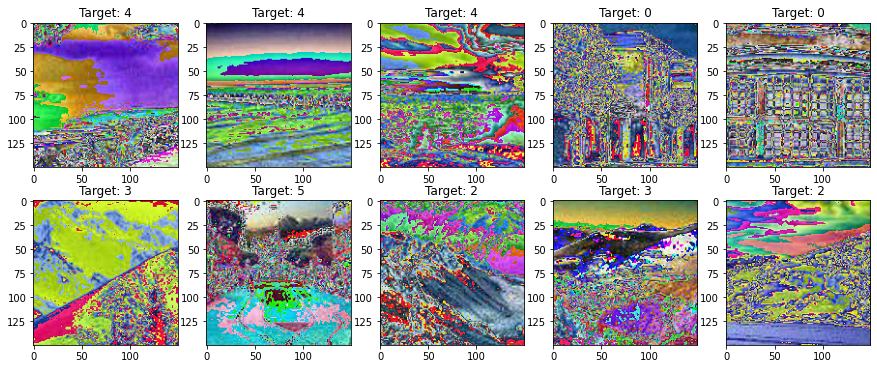

In [ ]:
data_root = "/content/Image_Transformations"

train_loader, test_loader = get_data(10, data_root)

plt.rcParams["figure.figsize"] = (15, 6)
plt.figure
for images, labels in train_loader:
    for i in range(len(labels)):
        plt.subplot(2, 5, i+1)
        img = transforms.functional.to_pil_image(images[i])
        plt.imshow(img)
        plt.gca().set_title('Target: {0}'.format(labels[i]))
    plt.show()
    break

In [ ]:
# YOUR CODE HERE for defining Transformation for an image
transformations = {
    'training': transforms.Compose([
        transforms.RandomResizedCrop(150),#remove
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# YOUR CODE HERE for the DataLoader

data_dir = '/content/Image_Transformations'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          transformations[x])
                  for x in ['training', 'validation']} #os.path.join(data_root, 'training')
loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['training', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation']}
class_names = image_datasets['training'].classes

In [ ]:
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
#encoder and decoder to convert classes into integer
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

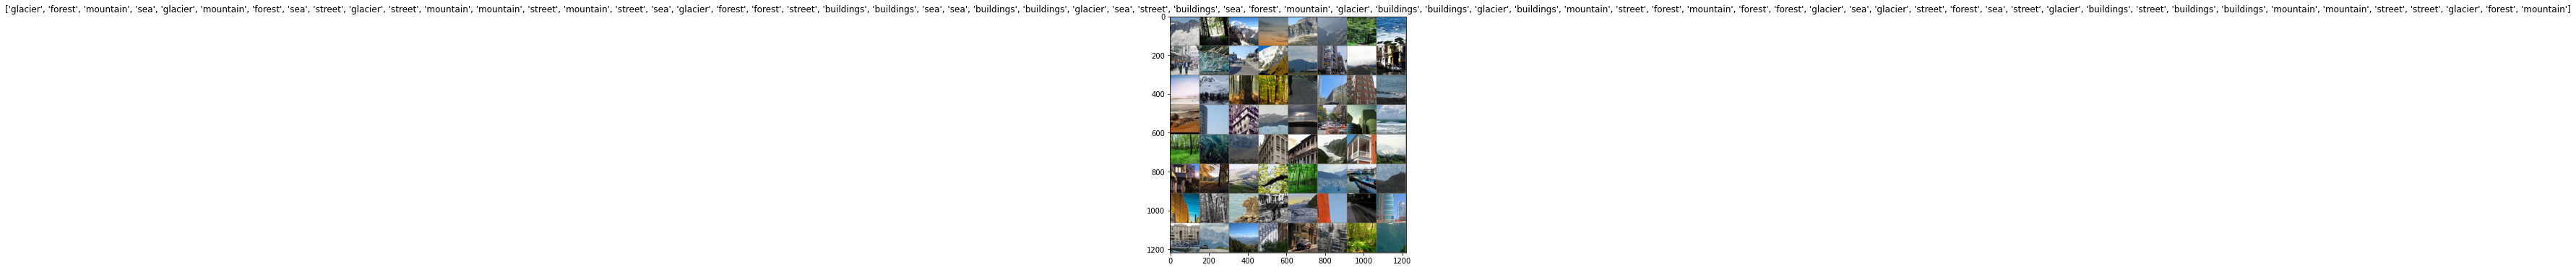

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.grid(False)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(loader['training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## **Stage 2:** Load and Finetune a pre-trained model

Load a pretrained model and finetune the appropriate layers



###  5 Marks -> Fine-tune the Model and declare the loss function and optimizer. 

[Hint for Finetuning Models](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

Initialize the device to the available runtime type

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # YOUR CODE HERE
 
print(device)

cuda:0


#### Finetuning the model
Loading a pretrained model and resetting the final fully connected layer.

ResNet is a short name for Residual Network. resnet18 contains 18 layers in which the last layer is chopped and a linear layer is added which is used to identify the bees images from ant images. 

In [ ]:
# YOUR CODE HERE for the loading and finetuning the Pre-trained model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 6)
model_ft = model_ft.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
# YOUR CODE HERE for declaring the loss function and optimizer   

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 5 Marks -> Train the Model to calculate the loss and accuracy for the dataset across each epoch.

Iterate over batch-wise images in the train_loader and perform the following steps. 

1. First, zero out the gradients using zero_grad()

2. Convert the inputs, labels to the device (runtime type: GPU or CPU)

3. Pass the input to the model and get the output

4. Calculate the loss by comparing output with actual labels using a Loss function

5. Perform Backward pass using backward() to update the weights

6. Optimize the weights at each epoch and get a high probability prediction using the torch.max()

7. Calculate the accuracy of the training dataset using the predictions

**Note:** Optimize the CNN model to get better accuracy.

## Expected Accuracy > 90%

In [ ]:
# YOUR CODE HERE 
# Record loss and accuracy of the training dataset for each epoch

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
               best_acc = epoch_acc
               best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


training Loss: 0.5473 Acc: 0.8054
validation Loss: 0.2931 Acc: 0.9000

Epoch 1/9
----------
training Loss: 0.3296 Acc: 0.8795
validation Loss: 0.2675 Acc: 0.9087

Epoch 2/9
----------
training Loss: 0.2965 Acc: 0.8921
validation Loss: 0.2446 Acc: 0.9080

Epoch 3/9
----------
training Loss: 0.2885 Acc: 0.8948
validation Loss: 0.2399 Acc: 0.9117

Epoch 4/9
----------
training Loss: 0.2666 Acc: 0.9038
validation Loss: 0.2243 Acc: 0.9200

Epoch 5/9
----------
training Loss: 0.2504 Acc: 0.9096
validation Loss: 0.2369 Acc: 0.9193

Epoch 6/9
----------
training Loss: 0.2386 Acc: 0.9146
validation Loss: 0.2190 Acc: 0.9210

Epoch 7/9
----------
training Loss: 0.2309 Acc: 0.9154
validation Loss: 0.2177 Acc: 0.9220

Epoch 8/9
----------
training Loss: 0.2289 Acc: 0.9148
validation Loss: 0.2169 Acc: 0.9210

Epoch 9/9
----------
training Loss: 0.2300 Acc: 0.9158
validation Loss: 0.2129 Acc: 0.9217

Training complete in 6m 20s
Best val Acc: 0.922000


In [ ]:
## Visualize predicted images
def visualize_model(model, num_images=6):
    #was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    #model.train(mode=was_training)
                    return
        #model.train(mode=was_training)

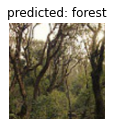

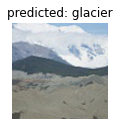

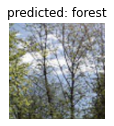

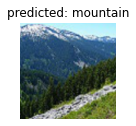

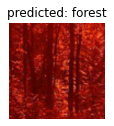

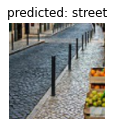

In [ ]:
visualize_model(model_ft)

### 5 Marks -> Validate the Model using the validation data

Iterate over batch-wise images in the validation_loader and perform the following steps. 

1. First, set the model in `eval()` mode

2. Convert the inputs, labels to the device (runtime type: GPU or CPU)

3. Pass the input to the model and get the output

4. Get high probability prediction using the torch.max()

5. Calculate the accuracy of the validation dataset using the predictions


## Expected Accuracy > 90%

**Note:** Optimize the CNN model to get better accuracy

[Hint for eval()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval)


In [ ]:
# YOUR CODE HERE 
# Display the accuracy of the validation dataset
correct = 0
total = 0
with torch.no_grad():
    model_ft.eval()
    for i, (inputs, labels) in enumerate(loader['validation']):

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)

        _, preds = torch.max(outputs, 1) #.data

        total += labels.size(0)
        correct += (preds == labels).sum().item()

print('Accuracy of the validation set: %d %%' % (100 * correct / total))

Accuracy of the validation set: 92 %


## **Stage 3:** Test your final architecture on variations of the Test data.



Variations of the Test data mean that you can consider any image transformation such as Brightness, rotation, flip, and so on, as shown in the below example. 

![alt text](https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/transformations.png)

### 12 Marks-> Define 6 different types of image transformation (variations) and evaluate for all test samples of various classes available.

1. Define **6 image transformations** (Eg: Brightness, rotate, flip, and so on). You can use either skimage, PIL, or anything which can give the image transformations.

2. Iterate over all **<font size='4.5'>TEN </font>** different test samples available under the testing folder run the below steps
   *  Perform 6 different image transformations for the chosen test sample and plot the same.
   *  Convert the image type of the transformed images, if required.
   *  Call the image_loader function for every transformed image.
   *  Pass through the CNN model to predict the label for each transformed test sample.
   *  Ensure the transformed test sample gives the correct prediction as an appropriate class name (buildings, forest, glacier, mountain, sea, and street) and **visualize the same**

## At least 4 transformed pictures should be predicted similar to the original base prediction

[Hint for the image transformations using skimage](https://www.analyticsvidhya.com/blog/2019/09/9-powerful-tricks-for-working-image-data-skimage-python/)

[Hint for the image transformations using PIL](https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/)

In [ ]:
# Import required libraries for image transformations
# check Pillow version number
import PIL
print('Pillow Version:', PIL.__version__)
# load and show an image with Pillow
from PIL import Image

import glob
from PIL import Image 


import cv2
import random

import matplotlib.gridspec as gridspec

Pillow Version: 7.0.0


In [ ]:
# YOUR CODE HERE for defining 6 different image transformations (eg: Brightness, rotate, flip, and so on)

# load the images
image_list = []
for filename in glob.glob('/content/Image_Transformations/testing/*.jpg'):  
    im=Image.open(filename)
    image_list.append(im)

In [ ]:
for img in image_list:
    plt.figure(figsize=(5, 5))
    plt.imshow(np.asarray(img))


In [ ]:
# Importing necessary functions 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
   
# Initialising the ImageDataGenerator class. 
# We will pass in the augmentation parameters in the constructor. 
datagen = ImageDataGenerator( 
        rotation_range = 40, 
        shear_range = 0.2, 
        zoom_range = 0.2, 
        horizontal_flip = True, 
        vertical_flip = True,
        brightness_range = (0.5, 1.5)) 
    
# Loading a sample image  
#img = load_img('/content/Image_Transformations/testing/11357.jpg')  
n = 1
for img in image_list:
    # Converting the input sample image to an array 
    x = img_to_array(img) 
    # Reshaping the input image 
    x = x.reshape((1, ) + x.shape)  
    
    # Generating and saving 5 augmented samples  
    # using the above defined parameters.  
    i = 0
    for batch in datagen.flow(x, batch_size = 1, 
                            save_to_dir ='/content/Image_Transformations/augment',  
                            save_prefix =n, save_format ='jpg'): 
        n +=1
        i += 1
        if i > 10: 
            break


In [ ]:
# load the augmented images
image_aug_list = []
for filename in glob.glob('/content/Image_Transformations/augment/*.jpg'):  
    im=Image.open(filename)
    image_aug_list.append(im)

In [ ]:
for img in image_aug_list:
    plt.figure(figsize=(5, 5))
    plt.imshow(np.asarray(img))

    

Output hidden; open in https://colab.research.google.com to view.

###call image loader

In [ ]:
def image_loader(image):
    image = loader(image).to(device)
    image = image.unsqueeze(0) # To pass single image through the model
    return image 

In [ ]:
for img in testImageLoader:
    plt.figure(figsize=(5, 5))
    plt.imshow(np.asarray(img))

###Prediction

Pass through the CNN model to predict the label for each transformed test sample.


Ensure the transformed test sample gives the correct prediction as an appropriate class name (**buildings, forest, glacier, mountain, sea, and street**) and visualize the same

In [ ]:
# YOUR CODE HERE for predicting the labels of an image for the 6 image transformations



In [ ]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return train_data.classes[preds[0].item()]

Predicted Class : street


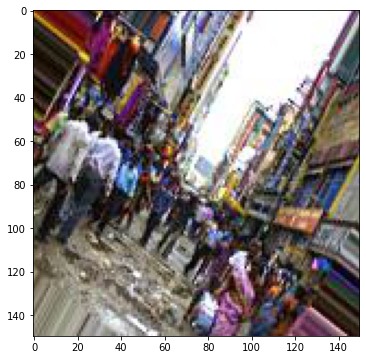

In [ ]:
#open image file
img = Image.open("/content/Image_Transformations/augment/78_0_3772.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model_ft)}")

Predicted Class : buildings


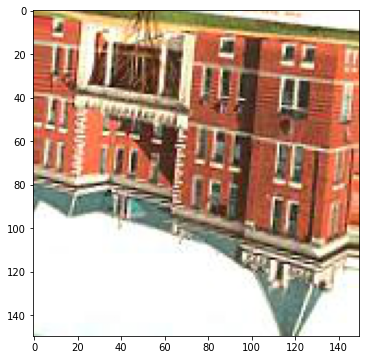

In [ ]:
#open image file
img = Image.open("/content/Image_Transformations/augment/43_0_4463.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model_ft)}")

Predicted Class : glacier


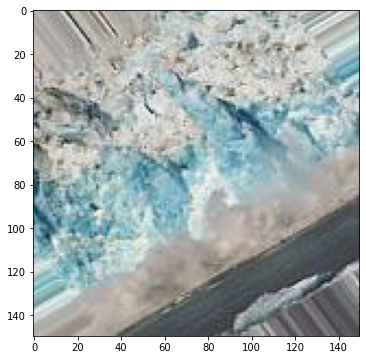

In [ ]:
#open image file
img = Image.open("/content/Image_Transformations/augment/8_0_5941.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model_ft)}")

Predicted Class : mountain


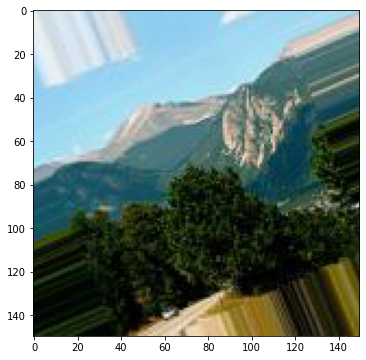

In [ ]:
#open image file
img = Image.open("/content/Image_Transformations/augment/23_0_7277.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model_ft)}")

Predicted Class : sea


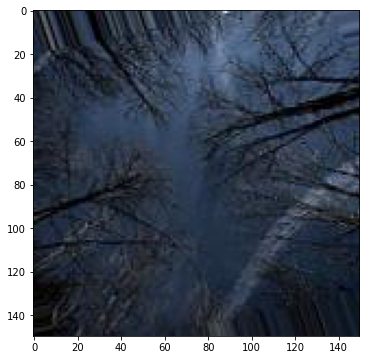

In [ ]:
#open image file
img = Image.open("/content/Image_Transformations/augment/45_0_8810.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model_ft)}")

Predicted Class : glacier


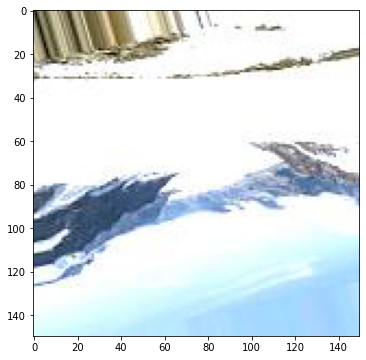

In [ ]:
#open image file
img = Image.open("/content/Image_Transformations/augment/64_0_79.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model_ft)}")

In [ ]:
for filename in glob.glob('/content/Image_Transformations/augment/*.jpg'):  
    im=Image.open(filename)
    #convert image to tensor
    img = transforms.ToTensor()(im)
    #print image
    plt.imshow(img.permute(1,2,0))

    #prdict image label
    print(f"Predicted Class : {predict_img_class(img,model_ft)}")


In [ ]:
for img in image_aug_list:
    #convert image to tensor
    img = transforms.ToTensor()(img)

    #print image
    plt.imshow(img.permute(1,2,0))

    #prdict image label
    print(f"Predicted Class : {predict_img_class(img,model_ft)}")
